<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-5/memoryschema_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 基于集合模式的聊天机器人

## 回顾

在前面的课程中，我们扩展了聊天机器人，使其能够将语义记忆保存到单个[用户档案](https://langchain-ai.github.io/langgraph/concepts/memory/#profile)中。

我们还介绍了一个名为[Trustcall](https://github.com/hinthornw/trustcall)的库，用于使用新信息更新这个模式。

## 学习目标

有时我们希望将记忆保存到[集合](https://docs.google.com/presentation/d/181mvjlgsnxudQI6S3ritg9sooNyu4AcLLFH1UK0kIuk/edit#slide=id.g30eb3c8cf10_0_200)中，而不是单个档案。

在这里，我们将更新聊天机器人以[将记忆保存到集合](https://langchain-ai.github.io/langgraph/concepts/memory/#collection)中。

我们还将展示如何使用[Trustcall](https://github.com/hinthornw/trustcall)来更新这个集合。

## 核心概念

### 什么是集合模式？
- **集合模式**：一种灵活的数据存储方式，允许我们存储多个独立的记忆条目
- **与档案模式的区别**：档案模式有固定的结构，而集合模式可以动态添加和更新记忆
- **优势**：更适合存储开放式的用户交互记忆，可以随着对用户了解的深入而增长和变化

### 技术栈
- **LangGraph**：用于构建状态图和工作流
- **Trustcall**：用于智能更新和插入记忆
- **Pydantic**：用于数据验证和序列化
- **OpenAI GPT-4**：作为语言模型


In [1]:
# 安装必要的依赖包
# 使用 %%capture 来隐藏安装过程中的输出信息
%%capture --no-stderr
# %pip install -U langchain_openai langgraph trustcall langchain_core
%pip install --quiet langchain_openai==0.3.32 langchain_core==0.3.75 langgraph==0.6.7 trustcall==0.0.39

In [2]:
# 导入必要的库
import os, getpass

def _set_env(var: str):
    """
    设置环境变量的辅助函数

    参数:
        var (str): 环境变量名称
    """
    # 检查环境变量是否已在操作系统中设置
    env_value = os.environ.get(var)
    if not env_value:
        # 如果未设置，提示用户输入
        env_value = getpass.getpass(f"{var}: ")

    # 为当前进程设置环境变量
    os.environ[var] = env_value

# 设置 LangSmith API 密钥（用于追踪和监控）
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"  # 启用追踪
os.environ["LANGSMITH_PROJECT"] = "FlyAIBox"  # 设置项目名称

LANGSMITH_API_KEY: ··········


## 定义集合模式

**与将用户信息存储在固定档案结构中不同，我们将创建一个灵活的集合模式来存储用户交互的记忆。**

每个记忆将作为单独的条目存储，包含一个 `content` 字段，用于存储我们想要记住的主要信息。

这种方法允许我们构建一个开放式的记忆集合，随着我们对用户了解的深入而增长和变化。

我们可以将集合模式定义为 [Pydantic](https://docs.pydantic.dev/latest/) 对象。

### 为什么使用集合模式？

1. **灵活性**：可以动态添加新的记忆类型，不受固定结构限制
2. **可扩展性**：随着对话的进行，记忆集合可以无限增长
3. **独立性**：每个记忆条目都是独立的，便于管理和更新
4. **语义搜索**：支持基于内容的语义搜索和检索

In [3]:
# 导入 Pydantic 用于数据验证和序列化
from pydantic import BaseModel, Field

class Memory(BaseModel):
    """
    单个记忆条目的数据模型

    属性:
        content (str): 记忆的主要内容，例如："用户表达了对学习法语的兴趣"
    """
    content: str = Field(description="记忆的主要内容。例如：用户表达了对学习法语的兴趣。")

class MemoryCollection(BaseModel):
    """
    记忆集合的数据模型

    属性:
        memories (list[Memory]): 关于用户的记忆列表
    """
    memories: list[Memory] = Field(description="关于用户的记忆列表。")

In [4]:
# 设置OpenAI API密钥
# 您需要从 https://api.apiyi.com/v1 获取API密钥
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们可以使用 LangChain 聊天模型接口的 [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) 方法来强制生成结构化输出。

### 什么是结构化输出？
- **结构化输出**：确保语言模型返回符合预定义模式的数据
- **优势**：保证数据格式的一致性，便于后续处理
- **应用场景**：提取信息、生成特定格式的响应等

In [5]:
# 导入必要的消息类型和模型
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

# 初始化 GPT-4o 模型
# temperature=0 确保输出更加确定性和一致
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 将记忆集合模式绑定到模型，确保输出符合我们的数据结构
model_with_structure = model.with_structured_output(MemoryCollection)

# 调用模型生成符合模式的结构化输出
# 输入："我的名字是FLY，我喜欢骑自行车。"
memory_collection = model_with_structure.invoke([HumanMessage("我的名字是FLY，我喜欢骑自行车。")])
memory_collection.memories

[Memory(content='用户的名字是FLY。'), Memory(content='用户喜欢骑自行车。')]

我们可以使用 `model_dump()` 方法将 Pydantic 模型实例序列化为 Python 字典。

### `model_dump()` 的作用

`model_dump()` 是 **Pydantic** 库中一个非常常用的方法，它的核心作用是**将一个 Pydantic 模型实例转换为一个 Python 字典（`dict`）**。

这个方法是 **Pydantic** 模型类自带的，你不需要额外导入它。当你有一个填充了数据的 Pydantic 对象时，`model_dump()` 可以帮助你轻松地获取这些数据，以便进行后续处理，比如：

  * **序列化为 JSON**：将模型数据发送给 API 接口。
  * **写入数据库**：将模型数据转换为数据库可接受的格式。
  * **调试和打印**：检查模型中的数据是否正确。

-----

### 主要参数和功能

`model_dump()` 提供了几个有用的参数来控制转换过程，让你能更灵活地处理数据。

#### 1\. `mode`

这是最重要的参数，它决定了如何处理数据：

  * **`'json'` (默认)**：这是最常用的模式。它会确保所有数据都能够被 JSON 序列化。例如，它会自动将 `datetime` 对象转换为 ISO 格式的字符串。
  * **`'python'`**：这种模式会尽量保留原始的 Python 类型。它不会像 `'json'` 模式那样对数据进行转换，适用于需要在 Python 环境中进一步处理的情况。

#### 2\. `include` 和 `exclude`

这两个参数让你能控制哪些字段被包含或排除在最终的字典中。

  * **`include`**：只包含你指定的字段。
  * **`exclude`**：排除你指定的字段。

你还可以使用嵌套的字典来指定要包含或排除子模型中的字段。

#### 3\. `by_alias`

Pydantic 允许你在模型中为字段定义别名（alias），以便在加载数据时使用不同的名称。

  * 当 `by_alias=True` 时，导出的字典会使用字段的**别名**作为键。这对于生成符合外部 API 要求的 JSON 数据非常有用。
  * 当 `by_alias=False` 时（默认），导出的字典会使用**原始的字段名**作为键。

### 示例

让我们通过一个简单的例子来理解 `model_dump()` 的用法。

```python
from datetime import datetime
from typing import Optional
from pydantic import BaseModel, Field

class User(BaseModel):
    id: int
    name: str = Field(alias='full_name')
    registration_date: datetime
    is_active: bool = True
    
# 创建一个 User 模型实例
user_data = {
    'id': 123,
    'full_name': '张三',
    'registration_date': datetime(2023, 1, 15, 10, 30, 0)
}
user = User.model_validate(user_data)

# 默认用法: mode='json'
# `full_name` 别名会被转换回 `name`
print(user.model_dump())
# 输出: {'id': 123, 'name': '张三', 'registration_date': '2023-01-15T10:30:00', 'is_active': True}

# 使用 by_alias=True
print(user.model_dump(by_alias=True))
# 输出: {'id': 123, 'full_name': '张三', 'registration_date': '2023-01-15T10:30:00', 'is_active': True}

# 使用 include
print(user.model_dump(include={'name', 'registration_date'}))
# 输出: {'name': '张三', 'registration_date': '2023-01-15T10:30:00'}

# 使用 exclude
print(user.model_dump(exclude={'is_active'}))
# 输出: {'id': 123, 'name': '张三', 'registration_date': '2023-01-15T10:30:00'}
```

总之，`model_dump()` 是 Pydantic 模型的一个重要工具，它让你能以一种灵活、可控的方式，将结构化的数据模型转换为通用的 Python 字典，从而方便地与其他系统或格式进行交互。

### 作用
- **数据转换**：将 Pydantic 对象转换为标准的 Python 字典
- **存储准备**：为后续存储到数据库或文件做准备
- **API 传输**：便于在 API 之间传输数据

In [6]:
# 将第一个记忆条目序列化为字典格式
memory_collection.memories[0].model_dump()

{'content': '用户的名字是FLY。'}

将每个记忆的字典表示保存到存储中。

### 存储机制说明
- **命名空间**：使用 (用户ID, "memories") 作为命名空间来组织记忆
- **唯一键**：为每个记忆生成唯一的 UUID 作为键
- **值存储**：将序列化后的记忆字典作为值存储

In [7]:
# 导入必要的库
import uuid
from langgraph.store.memory import InMemoryStore

# 初始化内存存储（用于演示，生产环境建议使用持久化存储）
in_memory_store = InMemoryStore()

# 定义存储记忆的命名空间
user_id = "1"  # 用户ID
namespace_for_memory = (user_id, "memories")  # 命名空间：(用户ID, "memories")

# 保存第一个记忆到存储中
key = str(uuid.uuid4())  # 生成唯一键
value = memory_collection.memories[0].model_dump()  # 序列化记忆
in_memory_store.put(namespace_for_memory, key, value)

# 保存第二个记忆到存储中
key = str(uuid.uuid4())  # 生成新的唯一键
value = memory_collection.memories[1].model_dump()  # 序列化记忆
in_memory_store.put(namespace_for_memory, key, value)

在存储中搜索记忆。

### 搜索功能说明
- **命名空间搜索**：在指定命名空间内搜索所有记忆
- **返回格式**：包含记忆内容、键、命名空间、创建和更新时间等信息
- **用途**：用于检索和显示已存储的用户记忆

In [8]:
# 搜索并显示存储中的所有记忆
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memories'], 'key': '066f78f4-a537-4cc0-8c66-eb801eeb3b1c', 'value': {'content': '用户的名字是FLY。'}, 'created_at': '2025-09-18T01:50:27.658978+00:00', 'updated_at': '2025-09-18T01:50:27.658981+00:00', 'score': None}
{'namespace': ['1', 'memories'], 'key': '5a42685e-523a-4507-b79f-e795fbbdb572', 'value': {'content': '用户喜欢骑自行车。'}, 'created_at': '2025-09-18T01:50:27.659149+00:00', 'updated_at': '2025-09-18T01:50:27.659150+00:00', 'score': None}


## 更新集合模式

我们在上一课中讨论了更新档案模式的挑战。

同样的挑战也适用于集合！

我们希望具备以下能力：
- 向集合中添加新记忆
- 更新集合中现有的记忆

现在我们将展示 [Trustcall](https://github.com/hinthornw/trustcall) 也可以用于更新集合。

这使我们能够同时进行新记忆的添加和[现有记忆的更新](https://github.com/hinthornw/trustcall?tab=readme-ov-file#simultanous-updates--insertions)。

让我们使用 Trustcall 定义一个新的提取器。

与之前一样，我们为每个记忆提供模式 `Memory`。

但是，我们可以设置 `enable_inserts=True` 来允许提取器向集合中插入新记忆。

### Trustcall 的优势

1. **智能更新**：能够识别哪些记忆需要更新，哪些需要新增
2. **并行处理**：同时处理更新和插入操作
3. **上下文感知**：基于对话上下文智能合并信息
4. **一致性保证**：确保记忆集合的一致性和准确性

In [27]:
# 导入 Trustcall 库
from trustcall import create_extractor

# 创建 Trustcall 提取器
# 配置参数说明：
# - model: 使用的语言模型
# - tools: 可用的工具列表（这里只有 Memory 工具）
# - tool_choice: 指定使用的工具
# - enable_inserts: 允许插入新记忆到集合中
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,  # 关键参数：允许插入新记忆
)

In [28]:
# 导入消息类型
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 定义提取指令
instruction = """从以下对话中提取记忆："""

# 模拟对话内容
conversation = [
    HumanMessage(content="你好，我是 FLY"),  # 用户：你好，我是 FLY
    AIMessage(content="很高兴认识你，FLY"),  # AI：很高兴认识你，FLY
    HumanMessage(content="今天早上我在湖边骑自行车")  # 用户：今天早上我在湖边骑自行车
]

# 调用提取器处理对话
# 将系统指令和对话消息组合后传递给提取器
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=instruction)] + conversation})

In [29]:
# 显示提取器返回的消息，包含工具调用信息
# result["messages"] 包含模型生成的消息和工具调用
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_xhY8DBgZqbkqXdoVnJIonGL2)
 Call ID: call_xhY8DBgZqbkqXdoVnJIonGL2
  Args:
    content: FLY 今天早上在湖边骑自行车。


In [30]:
# 显示提取的记忆，这些记忆符合我们定义的模式
# result["responses"] 包含符合 Memory 模式的记忆对象
for m in result["responses"]:
    print(m)

content='FLY 今天早上在湖边骑自行车。'


In [31]:
# 显示响应元数据，包含工具调用的详细信息
# result["response_metadata"] 包含每个响应的元数据信息
for m in result["response_metadata"]:
    print(m)

{'id': 'call_xhY8DBgZqbkqXdoVnJIonGL2'}


In [32]:
# 模拟对话的延续，用于演示记忆更新
updated_conversation = [
    AIMessage(content="太棒了，之后你做了什么？"),  # AI：太棒了，之后你做了什么？
    HumanMessage(content="我去了咖啡店喝了咖啡"),  # 用户：我去了咖啡店喝了咖啡
    AIMessage(content="你还想说什么？"),  # AI：你还想说什么？
    HumanMessage(content="我在想去日本旅游，想今年冬天再去"),  # 用户：我在想日本，想今年冬天再去
]

# 更新指令，要求更新现有记忆并创建新记忆
system_msg = """基于以下对话更新现有记忆并创建新记忆："""

# 准备现有记忆数据，用于 Trustcall 的更新功能
# 格式：(ID, 工具名称, 记忆内容字典)
tool_name = "Memory"
# 这行代码创建了一个名为 existing_memories 的列表，用于存储格式化后的现有记忆。
# 这个列表的格式是 Trustcall 提取器在处理更新和插入时所期望的。

# 列表中的每个元素都是一个元组 (ID, 工具名称, 记忆内容字典)。
# - (str(i), tool_name, memory.model_dump()) 是列表推导式中的一个元素。
# - enumerate(result["responses"]) 遍历 result["responses"] 列表，该列表包含之前提取到的 Memory 对象。
#   enumerate 返回索引 i 和对应的 Memory 对象 memory。

# - str(i) 将索引 i 转换为字符串作为记忆的 ID。这个 ID 用于标识要更新的现有记忆。
# - tool_name 是工具名称，这里是 "Memory"。
# - memory.model_dump() 将 Memory 对象序列化为 Python 字典，包含记忆的具体内容。

# - if result["responses"] else None 是一个条件表达式。如果 result["responses"] 列表不为空，则执行列表推导式创建列表；
#   否则，existing_memories 被设置为 None。这是因为如果之前没有提取到记忆，就不存在需要更新的现有记忆。
existing_memories = [(str(i), tool_name, memory.model_dump()) for i, memory in enumerate(result["responses"])] if result["responses"] else None
existing_memories

[('0', 'Memory', {'content': 'FLY 今天早上在湖边骑自行车。'})]

In [33]:
# 使用更新的对话和现有记忆调用提取器
# 这次调用将演示如何同时更新现有记忆和创建新记忆
result = trustcall_extractor.invoke({"messages": updated_conversation,
                                     "existing": existing_memories})

In [34]:
# 显示模型生成的消息，可以看到进行了两次工具调用
# 一次用于更新现有记忆，一次用于创建新记忆
for m in result["messages"]:
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  Memory (call_dxfDTvEWGGUwWI4BBSVPIglj)
 Call ID: call_dxfDTvEWGGUwWI4BBSVPIglj
  Args:
    content: FLY 去了咖啡店喝了咖啡。
  Memory (call_aQUNPGZ5RI5MuKiVcdLfQgUP)
 Call ID: call_aQUNPGZ5RI5MuKiVcdLfQgUP
  Args:
    content: FLY 想去日本旅游，计划今年冬天去。


In [38]:

    print(result)

{'messages': [AIMessage(content='', additional_kwargs={'updated_docs': {}}, response_metadata={}, id='ad844faf-5cff-4850-9233-7e148c30bf13', tool_calls=[{'name': 'Memory', 'args': {'content': 'FLY 去了咖啡店喝了咖啡。'}, 'id': 'call_dxfDTvEWGGUwWI4BBSVPIglj', 'type': 'tool_call'}, {'name': 'Memory', 'args': {'content': 'FLY 想去日本旅游，计划今年冬天去。'}, 'id': 'call_aQUNPGZ5RI5MuKiVcdLfQgUP', 'type': 'tool_call'}])], 'responses': [Memory(content='FLY 去了咖啡店喝了咖啡。'), Memory(content='FLY 想去日本旅游，计划今年冬天去。')], 'response_metadata': [{'id': 'call_dxfDTvEWGGUwWI4BBSVPIglj'}, {'id': 'call_aQUNPGZ5RI5MuKiVcdLfQgUP'}], 'attempts': 1}


In [35]:
# 显示更新后的记忆，包含合并和新增的内容
for m in result["responses"]:
    print(m)

content='FLY 去了咖啡店喝了咖啡。'
content='FLY 想去日本旅游，计划今年冬天去。'


这告诉我们通过指定 `json_doc_id` 更新集合中的第一个记忆。

### 更新机制说明
- **json_doc_id**: 用于标识要更新的现有记忆
- **无 json_doc_id**: 表示这是一个新记忆，将被插入到集合中
- **智能合并**: Trustcall 能够智能地将新信息与现有记忆合并

In [44]:
# 显示响应元数据，可以看到更新和插入的详细信息
for m in result["response_metadata"]:
    print(m)

{'id': 'call_dxfDTvEWGGUwWI4BBSVPIglj'}
{'id': 'call_aQUNPGZ5RI5MuKiVcdLfQgUP'}


### LangSmith 追踪

LangSmith 是一个用于监控和调试 LangChain 应用的平台。

追踪链接：https://smith.langchain.com/public/ebc1cb01-f021-4794-80c0-c75d6ea90446/r

### 追踪的作用
- **性能监控**：查看模型调用的延迟和成本
- **调试工具**：检查输入输出和中间步骤
- **质量评估**：分析模型响应的质量

## 集成集合模式更新的聊天机器人

现在，让我们将 Trustcall 集成到聊天机器人中，以创建和更新记忆集合。

### 系统架构

我们的聊天机器人将包含以下组件：

1. **状态图 (StateGraph)**：定义聊天机器人的工作流程
2. **记忆存储 (Memory Store)**：长期存储用户记忆
3. **检查点 (Checkpointer)**：短期存储对话状态
4. **Trustcall 提取器**：智能更新记忆集合
5. **语言模型**：生成响应

### 工作流程

1. 用户发送消息
2. 从存储中检索相关记忆
3. 基于记忆和对话历史生成响应
4. 使用 Trustcall 更新记忆集合
5. 返回响应给用户

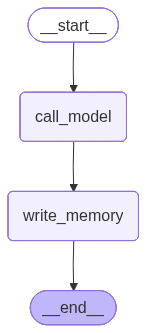

In [20]:
# 导入必要的库
from IPython.display import Image, display
import uuid

# LangGraph 相关导入
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.memory import InMemoryStore
from langchain_core.messages import merge_message_runs
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# 初始化 GPT-4o 模型
model = ChatOpenAI(model="gpt-4o", temperature=0)

# 定义记忆模式
class Memory(BaseModel):
    """单个记忆条目的数据模型"""
    content: str = Field(description="记忆的主要内容。例如：用户表达了对学习法语的兴趣。")

# 创建 Trustcall 提取器
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    enable_inserts=True,  # 允许插入新记忆
)

# 聊天机器人的系统提示词
MODEL_SYSTEM_MESSAGE = """你是一个有用的聊天机器人。你被设计为用户的伴侣。

你拥有长期记忆，能够跟踪你随时间了解到的用户信息。

当前记忆（可能包含本次对话中更新的记忆）：

{memory}"""

# Trustcall 的指令
TRUSTCALL_INSTRUCTION = """反思以下交互。

使用提供的工具来保留关于用户的任何必要记忆。

使用并行工具调用来同时处理更新和插入："""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    从存储中加载记忆并使用它们来个性化聊天机器人的响应。

    参数:
        state: 消息状态
        config: 运行配置
        store: 记忆存储

    返回:
        包含模型响应的状态更新
    """

    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]

    # 从存储中检索记忆
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # 格式化记忆用于系统提示词
    info = "\n".join(f"- {mem.value['content']}" for mem in memories)
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=info)

    # 使用记忆和聊天历史生成响应
    response = model.invoke([SystemMessage(content=system_msg)] + state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):
    """
    反思聊天历史并更新记忆集合。

    参数:
        state: 消息状态
        config: 运行配置
        store: 记忆存储
    """

    # 从配置中获取用户ID
    user_id = config["configurable"]["user_id"]

    # 定义记忆的命名空间
    namespace = ("memories", user_id)

    # 检索现有记忆作为上下文
    existing_items = store.search(namespace)

    # 为 Trustcall 提取器格式化现有记忆
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # 合并聊天历史和指令
    updated_messages = list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION)] + state["messages"]))

    # 调用提取器
    result = trustcall_extractor.invoke({"messages": updated_messages,
                                        "existing": existing_memories})

    # 将 Trustcall 的记忆保存到存储中
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# 定义状态图
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)  # 调用模型生成响应
builder.add_node("write_memory", write_memory)  # 写入记忆
builder.add_edge(START, "call_model")  # 开始 -> 调用模型
builder.add_edge("call_model", "write_memory")  # 调用模型 -> 写入记忆
builder.add_edge("write_memory", END)  # 写入记忆 -> 结束

# 长期记忆存储（跨线程）
across_thread_memory = InMemoryStore()

# 短期记忆检查点（线程内）
within_thread_memory = MemorySaver()

# 编译图，包含检查点和存储
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# 显示图的可视化
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [39]:
# 配置运行参数
# thread_id: 用于短期记忆（线程内）的线程ID
# user_id: 用于长期记忆（跨线程）的用户ID
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# 用户输入
input_messages = [HumanMessage(content="嗨，我是Fly")]

# 运行聊天机器人图
# stream_mode="values" 表示流式返回状态值
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

嗨，我是Fly
================================== Ai Message ==================================

嗨，Fly！很高兴再次和你聊天！最近有没有去湖边骑车或者逛面包店、咖啡店呢？


ERROR:extraction:Could not apply patch: can't remove a non-existent object ''
ERROR:extraction:Could not apply patch: can't remove a non-existent object ''


In [40]:
# 继续对话 - 用户提供更多信息
input_messages = [HumanMessage(content="我喜欢在湖边骑自行车")]

# 运行聊天机器人图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我喜欢在湖边骑自行车
================================== Ai Message ==================================

我记得你提过这个！湖边骑自行车真是个放松又健康的活动。最近有没有什么特别的骑行路线，或者有没有发现什么新的风景？


ERROR:extraction:Could not apply patch: can't remove a non-existent object ''
ERROR:extraction:Could not apply patch: can't remove a non-existent object ''


In [41]:
# 检查存储的记忆
# 定义记忆命名空间
user_id = "1"
namespace = ("memories", user_id)

# 搜索并显示所有存储的记忆
memories = across_thread_memory.search(namespace)
for m in memories:
    print(m.dict())

{'namespace': ['memories', '1'], 'key': '61a02b8b-4e91-4036-9807-4c60e01b2e30', 'value': {'content': '用户自我介绍为Fly。'}, 'created_at': '2025-09-18T02:10:34.552754+00:00', 'updated_at': '2025-09-18T02:10:34.552756+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '7172f9ca-676a-45ad-a708-ca473fbfa8a2', 'value': {'content': '用户喜欢在湖边骑自行车。'}, 'created_at': '2025-09-18T02:10:50.489321+00:00', 'updated_at': '2025-09-18T02:10:50.489323+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '6caf57e1-fa97-4c8d-a25e-69d0f774d691', 'value': {'content': '用户喜欢去面包店。'}, 'created_at': '2025-09-18T03:39:23.616651+00:00', 'updated_at': '2025-09-18T03:39:23.616653+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': '3685dd8c-42ac-44e9-a221-3c0536848ae2', 'value': {'content': '用户喜欢去咖啡店。'}, 'created_at': '2025-09-18T03:39:39.599828+00:00', 'updated_at': '2025-09-18T03:39:39.599830+00:00', 'score': None}
{'namespace': ['memories', '1'], 'key': 'd051d0e9-e4af-4623-92da-d3ff825157

In [45]:
# 继续对话 - 用户提供更多偏好信息
input_messages = [HumanMessage(content="我也喜欢去咖啡店")]

# 运行聊天机器人图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

我也喜欢去咖啡店
================================== Ai Message ==================================

我记得你之前提到过你喜欢去咖啡店！看来咖啡店对你来说是个特别的地方呢。是因为喜欢那里的氛围，还是享受一杯咖啡的悠闲时光？或者你会在那里做一些特别的事情，比如读书、工作，还是单纯地放松？如果你愿意分享，我很乐意听听！


在新线程中继续对话。

### 新线程的作用
- **独立对话**：新线程不会继承之前线程的短期记忆
- **长期记忆保持**：用户的长期记忆仍然可用
- **测试记忆功能**：验证聊天机器人是否能正确使用长期记忆

In [43]:
# 使用新的线程ID，但保持相同的用户ID
# 这样可以测试长期记忆是否正常工作
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# 用户询问推荐，这将测试聊天机器人是否能使用之前存储的记忆
input_messages = [HumanMessage(content="您推荐哪些咖啡给我？")]

# 运行聊天机器人图
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

您推荐哪些咖啡给我？
================================== Ai Message ==================================

Fly，我记得你之前问过这个问题！我推荐的咖啡种类可以根据你的口味和喜好来调整。如果你还没有尝试过以下这些，可以考虑：

1. **拿铁（Latte）**：奶味浓郁，适合喜欢顺滑口感的人。
2. **卡布奇诺（Cappuccino）**：奶泡丰富，口感更浓郁。
3. **摩卡（Mocha）**：咖啡与巧克力的完美结合，适合甜食爱好者。
4. **冷萃咖啡（Cold Brew）**：清爽低酸度，特别适合夏天。
5. **特调咖啡**：尝试咖啡店的特色创意，比如加入水果或香料的特调。

如果你有特别喜欢的口味，比如偏甜、偏苦或者喜欢尝试新奇的风味，可以告诉我，我会根据你的偏好再调整推荐！


### LangSmith 追踪

LangSmith 追踪链接：https://smith.langchain.com/public/c87543ec-b426-4a82-a3ab-94d01c01d9f4/r

### LangGraph Studio

LangGraph Studio 是一个可视化工具，用于：
- **图可视化**：查看聊天机器人的工作流程
- **调试**：检查每个节点的输入输出
- **测试**：交互式测试聊天机器人功能

![LangGraph Studio 界面截图](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0876d3daa19fef993ba_Screenshot%202024-11-11%20at%207.50.21%E2%80%AFPM.png)

## 总结

### 本课程学到的内容

1. **集合模式**：使用灵活的集合结构存储用户记忆
2. **Trustcall 集成**：智能更新和插入记忆
3. **LangGraph 工作流**：构建复杂的聊天机器人系统
4. **记忆管理**：区分短期和长期记忆
5. **状态图**：使用节点和边定义工作流程

### 实际应用场景

- **个性化助手**：记住用户偏好和习惯
- **客服机器人**：维护客户历史记录
- **教育应用**：跟踪学习进度和兴趣
- **健康管理**：记录健康数据和目标